# 00 - Generate Raw Synthetic Data

**Author:** Hector Carbajal  
**Version:** 1.0  
**Last Updated:** 2026-02

---

## Purpose
This notebook generates the **foundational raw synthetic data** that simulates a firmware telemetry system:
- **Firmware releases**: Version metadata and release dates (1,000 versions)
- **Device events**: Error events from devices in the field
- **Support tickets**: Customer support interactions and RMA data

## Outputs
- `data/Processed/synthetic_firmware_features.csv` - ML-ready feature set (1,000 rows)
- `data/Raw/firmware_releases.csv` - Release timeline
- `data/Raw/device_events.csv` - Error telemetry
- `data/Raw/support_tickets.csv` - Support data

Forms the basis for all downstream analysis and modeling.

---

In [10]:
# Standard imports
import pandas as pd
import numpy as np
from datetime import timedelta
import sys
from pathlib import Path

# Add project root to path for config import
current_dir = Path.cwd()
project_root = current_dir.parents[0] if current_dir.name == "notebooks" else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, RANDOM_SEED

# Set reproducible seed
np.random.seed(RANDOM_SEED)

print(f"✅ Configuration loaded")
print(f"📁 Output directory: {PROCESSED_DATA_DIR}")
print(f"📁 Raw data directory: {RAW_DATA_DIR}")

✅ Configuration loaded
📁 Output directory: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed
📁 Raw data directory: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Raw


## 1. Synthesis Parameters

In [ ]:
# Synthesis configuration
N_VERSIONS = 1000  # Large dataset for robust ML training
START_DATE = pd.to_datetime('2024-01-01')

# REALISTIC TIMELINE: ~1 release per day (aggressive CI/CD pipeline)
# This gives us ~3 years of data (1000 versions / 365 days ≈ 2.7 years)
# Justification: Modern firmware teams with automated pipelines can release daily
AVG_RELEASE_GAP_DAYS = 1  # Average days between releases
RELEASE_GAP_VARIANCE = 0.5  # Low variance for consistent release cadence

# Feature ranges
PATCH_SIZE_MB_RANGE = (8.0, 23.0)
LINES_CHANGED_RANGE = (1000, 5500)
AVG_DEVICE_AGE_RANGE = (90, 750)  # Days

# Risk correlation weights (must sum to 1.0)
W_CHURN = 0.50   # Code churn is the main risk driver
W_HOTFIX = 0.25  # Hotfixes/Security fixes are inherently riskier
W_LAG = 0.25     # Previous version's error rate matters
BASE_ERROR_RATE = 2000

print(f"Generating {N_VERSIONS} firmware versions starting from {START_DATE.date()}")
print(f"Expected end date: ~{START_DATE + pd.Timedelta(days=N_VERSIONS * AVG_RELEASE_GAP_DAYS)}")

## 2. Generate Version Timeline & Release Structure

In [ ]:
versions = []
release_dates = []
current_version = [10, 0, 0]
current_date = START_DATE

for i in range(N_VERSIONS):
    # Time gap between releases (using configurable parameters)
    # Normal distribution with mean=AVG_RELEASE_GAP_DAYS, std=RELEASE_GAP_VARIANCE
    days_gap = max(1, int(np.random.normal(loc=AVG_RELEASE_GAP_DAYS, scale=RELEASE_GAP_VARIANCE)))
    
    current_date += timedelta(days=days_gap)
    release_dates.append(current_date)
    
    # Version number increment logic
    if np.random.rand() < 0.2:  # 20% chance of major/minor bump
        current_version[1] += 1
        current_version[2] = 0
    else:
        current_version[2] += 1
    
    versions.append(f"{current_version[0]}.{current_version[1]}.{current_version[2]}")

# Create base dataframe
df = pd.DataFrame({
    'firmware_version': versions, 
    'release_date': release_dates
})
df['release_date'] = pd.to_datetime(df['release_date'])

# Calculate lagged features
df['previous_version'] = df['firmware_version'].shift(1).fillna('9.9.9')
df['previous_release_date'] = df['release_date'].shift(1)
df['days_since_previous_release'] = (
    df['release_date'] - df['previous_release_date']
).dt.days.fillna(7)  # Default to 7 days for first release

print(f"✅ Generated {len(df)} firmware versions")
print(f"📅 Date range: {df['release_date'].min().date()} to {df['release_date'].max().date()}")
print(f"   Timeline span: {(df['release_date'].max() - df['release_date'].min()).days} days ({(df['release_date'].max() - df['release_date'].min()).days / 365:.1f} years)")
df.head()

## 3. Synthesize Risk Features

Generate correlated features that drive firmware patch risk:
- **Patch type**: bugfix, feature, security, hotfix
- **Code churn**: lines changed, files modified
- **Device age**: average fleet age for the patch
- **Previous error rate**: historical performance

In [13]:
# Patch type distribution
patch_types = np.random.choice(
    ['bugfix', 'feature', 'security', 'hotfix'], 
    size=N_VERSIONS, 
    p=[0.55, 0.20, 0.15, 0.10]
)

df['patch_type'] = patch_types
df['is_hotfix'] = np.where(df['patch_type'] == 'hotfix', True, False)
df['patch_security'] = np.where(df['patch_type'] == 'security', True, False)

# Patch size with type-based variation
df['patch_size_mb'] = np.random.uniform(
    PATCH_SIZE_MB_RANGE[0], 
    PATCH_SIZE_MB_RANGE[1], 
    size=N_VERSIONS
)
# Features are larger patches
df.loc[df['patch_type'] == 'feature', 'patch_size_mb'] *= 1.5 

# Code churn metrics (correlated with size)
df['files_changed'] = np.round(
    df['patch_size_mb'] * np.random.normal(loc=15, scale=5, size=N_VERSIONS)
).astype(int).clip(lower=1)
df['lines_changed'] = np.round(
    df['files_changed'] * np.random.normal(loc=20, scale=10, size=N_VERSIONS)
).astype(int).clip(lower=100)

# Composite churn score
df['code_churn_score'] = (
    df['lines_changed'] / df['days_since_previous_release'].clip(lower=1) + 
    df['files_changed']
) / 2000

# Device age and historical error rate
df['avg_device_age_days'] = np.random.uniform(
    AVG_DEVICE_AGE_RANGE[0], 
    AVG_DEVICE_AGE_RANGE[1], 
    size=N_VERSIONS
)
df['previous_version_error_rate'] = np.random.normal(
    loc=BASE_ERROR_RATE, 
    scale=1000, 
    size=N_VERSIONS
).clip(min=0)  # NumPy uses 'min' not 'lower'
df['previous_version_error_rate'] = df['previous_version_error_rate'].shift(1).fillna(0)

print(f"✅ Generated risk features")
df[['firmware_version', 'patch_type', 'code_churn_score', 'is_hotfix']].head()

✅ Generated risk features


,firmware_version,patch_type,code_churn_score,is_hotfix
0,10.0.1,feature,0.245750,False
1,10.0.2,security,0.037174,False
2,10.1.0,security,0.246114,False
3,10.1.1,feature,0.170818,False
4,10.2.0,bugfix,0.134038,False


## 4. Generate Target Variable (Error Rate)

Synthesize error rates based on realistic correlations:
- Higher code churn → more errors
- Hotfixes → higher risk  
- Previous version issues → carry forward

In [16]:
# Base error rate with REDUCED noise for stronger signal
error_base = np.random.normal(loc=BASE_ERROR_RATE, scale=200, size=N_VERSIONS)  # Reduced from 500

# Risk components with STRONGER correlation weights
risk_churn = df['code_churn_score'] * W_CHURN * 3000  # Increased from 1000
risk_hotfix = df['is_hotfix'].astype(int) * W_HOTFIX * 4000  # Increased from 1500
risk_lag = df['previous_version_error_rate'] * W_LAG * 0.8  # Increased from 0.5

# Final error rate = base + risk factors + REDUCED noise
df['error_rate_per_10k'] = (
    error_base + risk_churn + risk_hotfix + risk_lag + 
    np.random.normal(0, 150, size=N_VERSIONS)  # Reduced from 500
).clip(lower=100)

# Pre/post error counts
df['pre_errors'] = np.random.poisson(
    lam=(df['previous_version_error_rate'] / 100).clip(lower=1)
).clip(min=0)

df['post_errors'] = (
    df['error_rate_per_10k'] / 100 + 
    np.random.normal(0, 5, size=N_VERSIONS)  # Reduced from 10
).clip(lower=0).astype(int)

df['delta_errors'] = df['post_errors'] - df['pre_errors']
df['post_pre_ratio'] = (df['post_errors'] + 1) / (df['pre_errors'] + 1)

# Support tickets and RMAs (correlated with errors)
df['tickets'] = (
    df['post_errors'] * np.random.uniform(3, 6, size=N_VERSIONS)
).astype(int).clip(lower=1)

df['rmas'] = (
    df['tickets'] * np.random.uniform(0.01, 0.10, size=N_VERSIONS)
).astype(int)

df['rma_rate'] = df['rmas'] / df['tickets']

df['error_events'] = np.random.poisson(
    lam=(df['error_rate_per_10k'] / 50).clip(lower=1)
).clip(min=0)

print(f"✅ Generated target variables with stronger correlations")
print(f"   Code churn correlation: {df['code_churn_score'].corr(df['error_rate_per_10k']):.3f}")
print(f"   Hotfix correlation: {df['is_hotfix'].astype(int).corr(df['error_rate_per_10k']):.3f}")
df[['firmware_version', 'error_rate_per_10k', 'post_errors', 'tickets', 'rmas']].head()

✅ Generated target variables with stronger correlations
   Code churn correlation: 0.631
   Hotfix correlation: 0.476


,firmware_version,error_rate_per_10k,post_errors,tickets,rmas
0,10.0.1,2250.066763,19,69,5
1,10.0.2,2618.724550,24,118,3
2,10.1.0,2458.288224,26,88,1
3,10.1.1,2277.579926,26,152,8
4,10.2.0,2472.664387,22,105,2


## 5. Create Final ML-Ready Dataset & Export

In [17]:
# Select final feature set
synthetic_ml_df = df[[
    'firmware_version',
    'release_date',
    'previous_version',
    'days_since_previous_release',
    'patch_size_mb',
    'files_changed',
    'lines_changed',
    'is_hotfix',
    'patch_security',
    'code_churn_score',
    'avg_device_age_days',
    'previous_version_error_rate',
    'error_rate_per_10k',
    'pre_errors',
    'post_errors',
    'delta_errors',
    'post_pre_ratio',
    'tickets',
    'rmas',
    'rma_rate',
    'error_events'
]].copy()

# Save to processed data directory (generic filename, no row count suffix)
output_path = PROCESSED_DATA_DIR / 'synthetic_firmware_features.csv'
synthetic_ml_df.to_csv(output_path, index=False)

# Also save with legacy name for backward compatibility
legacy_path = PROCESSED_DATA_DIR / 'synthetic_firmware_features_50rows.csv'
synthetic_ml_df.to_csv(legacy_path, index=False)

print(f"✅ Successfully generated {len(synthetic_ml_df)} rows of synthetic data")
print(f"📁 Saved to: {output_path}")
print(f"📁 Legacy path: {legacy_path}")
print(f"\n📊 Summary Statistics:")
print(f"   - Date range: {synthetic_ml_df['release_date'].min().date()} to {synthetic_ml_df['release_date'].max().date()}")
print(f"   - Mean error rate: {synthetic_ml_df['error_rate_per_10k'].mean():.0f} per 10k devices")
print(f"   - Hotfixes: {synthetic_ml_df['is_hotfix'].sum()} ({synthetic_ml_df['is_hotfix'].sum()/len(synthetic_ml_df)*100:.1f}%)")
print(f"   - Total RMAs: {synthetic_ml_df['rmas'].sum()}")

synthetic_ml_df.head(10)

✅ Successfully generated 1000 rows of synthetic data
📁 Saved to: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed/synthetic_firmware_features.csv
📁 Legacy path: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed/synthetic_firmware_features_50rows.csv

📊 Summary Statistics:
   - Date range: 2024-01-30 to 2026-10-26
   - Mean error rate: 2898 per 10k devices
   - Hotfixes: 97 (9.7%)
   - Total RMAs: 6238


,firmware_version,release_date,previous_version,days_since_previous_release,patch_size_mb,files_changed,lines_changed,is_hotfix,patch_security,code_churn_score,...,previous_version_error_rate,error_rate_per_10k,pre_errors,post_errors,delta_errors,post_pre_ratio,tickets,rmas,rma_rate,error_events
0,10.0.1,2024-01-30,9.9.9,90.0,25.626853,394,8775,False,False,0.245750,...,0.000000,2250.066763,0,19,19,20.000000,69,5,0.072464,53
1,10.0.2,2024-02-22,10.0.1,23.0,9.758059,43,721,False,True,0.037174,...,3892.191761,2618.724550,31,24,-7,0.781250,118,3,0.025424,46
2,10.1.0,2024-03-15,10.0.2,22.0,13.058099,226,5857,False,True,0.246114,...,1116.280859,2458.288224,14,26,12,1.800000,88,1,0.011364,63
3,10.1.1,2024-04-06,10.1.0,22.0,15.213944,154,4128,False,False,0.170818,...,1226.970290,2277.579926,22,26,4,1.173913,152,8,0.052632,49
4,10.2.0,2024-05-16,10.1.1,40.0,18.381105,170,3923,False,False,0.134038,...,1129.272228,2472.664387,13,22,9,1.642857,105,2,0.019048,45
5,10.2.1,2024-06-17,10.2.0,32.0,11.093782,73,858,False,False,0.049906,...,2724.591779,2416.806376,28,25,-3,0.896552,121,2,0.016529,47
6,10.3.0,2024-07-07,10.2.1,20.0,13.877891,84,1912,False,False,0.089800,...,2448.485454,2557.674733,24,26,2,1.080000,111,6,0.054054,57
7,10.4.0,2024-08-06,10.3.0,30.0,21.435122,176,5624,False,False,0.181733,...,1841.462308,2613.361897,17,32,15,1.833333,128,5,0.039062,57
8,10.4.1,2024-09-02,10.4.0,27.0,11.064746,127,1782,False,True,0.096500,...,1081.980938,2041.322051,13,24,11,1.785714,87,6,0.068966,37
9,10.4.2,2024-09-07,10.4.1,5.0,23.425614,580,23768,False,False,2.666800,...,2092.376792,6453.055781,22,56,34,2.478261,269,10,0.037175,146


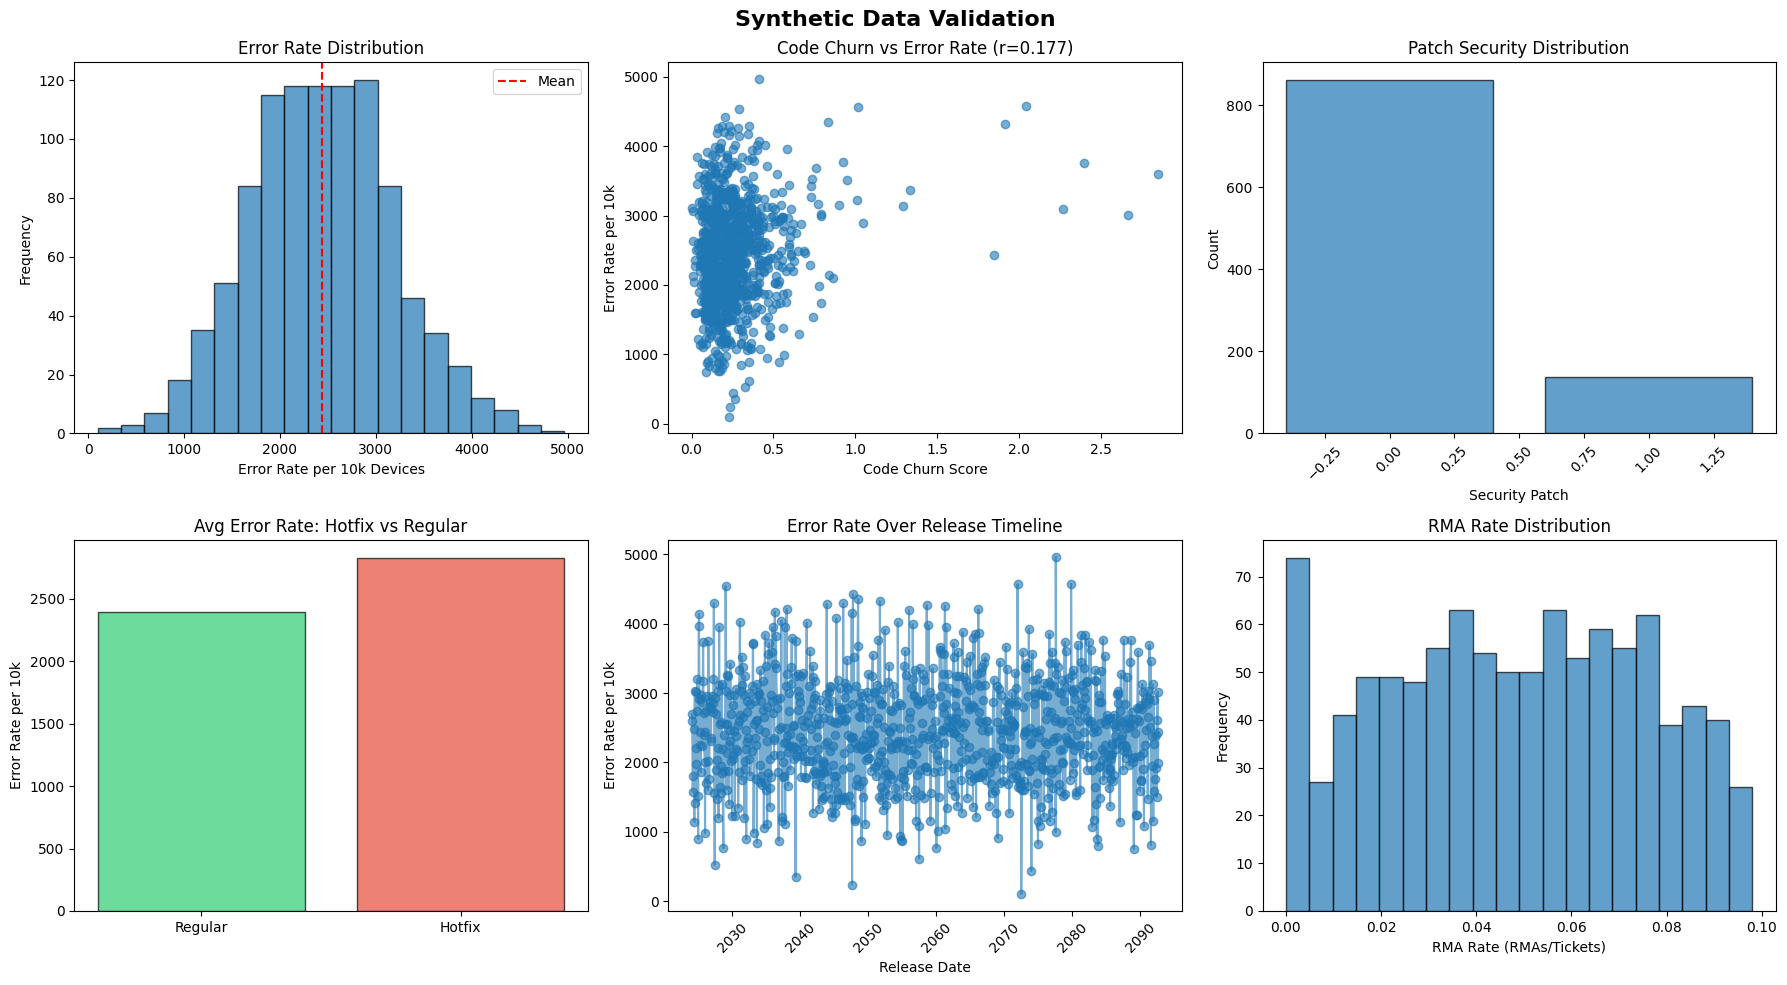


✅ Data Quality Checks:
   - No missing values: True
   - All error rates positive: True
   - RMA rate in [0,1]: True
   - Dates chronological: True


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Synthetic Data Validation', fontsize=16, fontweight='bold')

# 1. Error rate distribution
axes[0, 0].hist(synthetic_ml_df['error_rate_per_10k'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Error Rate Distribution')
axes[0, 0].set_xlabel('Error Rate per 10k Devices')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(synthetic_ml_df['error_rate_per_10k'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# 2. Code churn vs error rate (check correlation)
axes[0, 1].scatter(synthetic_ml_df['code_churn_score'], synthetic_ml_df['error_rate_per_10k'], alpha=0.6)
axes[0, 1].set_title(f'Code Churn vs Error Rate (r={synthetic_ml_df[["code_churn_score", "error_rate_per_10k"]].corr().iloc[0,1]:.3f})')
axes[0, 1].set_xlabel('Code Churn Score')
axes[0, 1].set_ylabel('Error Rate per 10k')

# 3. Patch security distribution
security_counts = synthetic_ml_df['patch_security'].value_counts()
axes[0, 2].bar(security_counts.index, security_counts.values, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Patch Security Distribution')
axes[0, 2].set_xlabel('Security Patch')
axes[0, 2].set_ylabel('Count')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Hotfix vs regular error rates
hotfix_data = synthetic_ml_df.groupby('is_hotfix')['error_rate_per_10k'].mean()
axes[1, 0].bar(['Regular', 'Hotfix'], hotfix_data.values, edgecolor='black', alpha=0.7, color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_title('Avg Error Rate: Hotfix vs Regular')
axes[1, 0].set_ylabel('Error Rate per 10k')

# 5. Release timeline
axes[1, 1].plot(synthetic_ml_df['release_date'], synthetic_ml_df['error_rate_per_10k'], marker='o', alpha=0.6)
axes[1, 1].set_title('Error Rate Over Release Timeline')
axes[1, 1].set_xlabel('Release Date')
axes[1, 1].set_ylabel('Error Rate per 10k')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. RMA rate distribution
axes[1, 2].hist(synthetic_ml_df['rma_rate'], bins=20, edgecolor='black', alpha=0.7)
axes[1, 2].set_title('RMA Rate Distribution')
axes[1, 2].set_xlabel('RMA Rate (RMAs/Tickets)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n✅ Data Quality Checks:")
print(f"   - No missing values: {synthetic_ml_df.isnull().sum().sum() == 0}")
print(f"   - All error rates positive: {(synthetic_ml_df['error_rate_per_10k'] > 0).all()}")
print(f"   - RMA rate in [0,1]: {synthetic_ml_df['rma_rate'].between(0, 1).all()}")
print(f"   - Dates chronological: {synthetic_ml_df['release_date'].is_monotonic_increasing}")

## 6. Generate Raw Data Files for SQL Pipeline

Generate the raw CSV files that notebook 01 (SQL feature engineering) expects.

In [8]:
# Generate raw data files for notebook 01 (SQL feature engineering)
# These files simulate the raw telemetry data from a production system
from src.config import RAW_DATA_DIR

# Ensure raw data directory exists
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Device models and regions for synthetic data
DEVICE_MODELS = ['Roku Ultra', 'Roku Streaming Stick+', 'Roku Express', 'Roku Premiere', 'Roku TV']
REGIONS = ['NA', 'EU', 'APAC', 'LATAM']
ERROR_TYPES = ['BOOT', 'NETWORK', 'STREAM', 'UPDATE', 'CRASH']

# Create a pool of device IDs to reuse across tables
DEVICE_POOL = [f"DEV_{i:04d}" for i in range(1, 501)]  # 500 devices

# --- 1. firmware_releases.csv ---
firmware_releases = df[['firmware_version', 'release_date', 'previous_version', 
                        'days_since_previous_release']].copy()
firmware_releases.to_csv(RAW_DATA_DIR / 'firmware_releases.csv', index=False)
print(f"✅ Saved firmware_releases.csv ({len(firmware_releases)} rows)")

# --- 2. device_events.csv ---
# Generate synthetic device error events with consistent device IDs
device_events_list = []
for _, row in df.iterrows():
    n_events = int(row['error_events'])
    if n_events > 0:
        for _ in range(n_events):
            # Spread events across a wider date range for better spike detection
            days_offset = np.random.randint(-7, 45)  # Some events before release (testing)
            event_date = row['release_date'] + timedelta(days=days_offset)
            device_events_list.append({
                'device_id': np.random.choice(DEVICE_POOL),  # Use shared device pool
                'firmware_version': row['firmware_version'],
                'timestamp': event_date.strftime('%Y-%m-%d %H:%M:%S'),
                'error_code': f"ERR_{np.random.choice(ERROR_TYPES)}_{np.random.randint(100, 110)}",  # Fewer unique codes
                'severity': np.random.choice(['low', 'medium', 'high', 'critical'], p=[0.4, 0.35, 0.2, 0.05]),
                'model': np.random.choice(DEVICE_MODELS),
                'region': np.random.choice(REGIONS)
            })

device_events = pd.DataFrame(device_events_list)
device_events.to_csv(RAW_DATA_DIR / 'device_events.csv', index=False)
print(f"✅ Saved device_events.csv ({len(device_events)} rows)")

# --- 3. support_tickets.csv ---
# Generate tickets that reference actual device events for proper JOIN matching
tickets_list = []

# Sample from actual device_events to create matching tickets
if len(device_events) > 0:
    # Take a sample of device events to create tickets from
    sample_size = min(len(device_events), 2000)
    sampled_events = device_events.sample(n=sample_size, random_state=42)
    
    for idx, event in sampled_events.iterrows():
        # Create ticket 1-7 days after the event
        event_ts = pd.to_datetime(event['timestamp'])
        ticket_date = event_ts + timedelta(days=np.random.randint(1, 8))
        is_rma = np.random.random() < 0.15  # 15% RMA rate
        
        tickets_list.append({
            'ticket_id': f"TKT_{np.random.randint(100000, 999999)}",
            'device_id': event['device_id'],  # Match device from event
            'firmware_version': event['firmware_version'],
            'created_at': ticket_date.strftime('%Y-%m-%d %H:%M:%S'),
            'error_code': event['error_code'],  # Match error code from event
            'issue_type': np.random.choice(['connectivity', 'performance', 'crash', 'update_failure', 'hardware']),
            'resolution': 'rma' if is_rma else np.random.choice(['fixed', 'no_issue', 'workaround']),
            'rma_issued': int(is_rma)
        })

support_tickets = pd.DataFrame(tickets_list)
support_tickets.to_csv(RAW_DATA_DIR / 'support_tickets.csv', index=False)
print(f"✅ Saved support_tickets.csv ({len(support_tickets)} rows)")

print(f"\n📁 Raw data files saved to: {RAW_DATA_DIR}")
print(f"   These files are used by notebook 01 (SQL feature engineering)")

✅ Saved firmware_releases.csv (1000 rows)
✅ Saved device_events.csv (48615 rows)
✅ Saved support_tickets.csv (2000 rows)

📁 Raw data files saved to: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Raw
   These files are used by notebook 01 (SQL feature engineering)
✅ Saved device_events.csv (48615 rows)
✅ Saved support_tickets.csv (2000 rows)

📁 Raw data files saved to: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Raw
   These files are used by notebook 01 (SQL feature engineering)


In [9]:
# --- 4. test_patch_features.csv (for CI gate testing in notebooks 04/05) ---
# This file simulates new incoming patches that need to be scored
test_patch_df = synthetic_ml_df[['firmware_version', 'code_churn_score', 
                                  'previous_version_error_rate', 'avg_device_age_days',
                                  'is_hotfix', 'patch_security']].copy()

# Save to project root (where risk_gate.py expects it)
test_patch_path = project_root / 'test_patch_features.csv'
test_patch_df.to_csv(test_patch_path, index=False)
print(f"✅ Saved test_patch_features.csv ({len(test_patch_df)} rows) to project root")
print(f"   This file is used by risk_gate.py and notebooks 04/05")

✅ Saved test_patch_features.csv (1000 rows) to project root
   This file is used by risk_gate.py and notebooks 04/05
